# Tutorial code: Simplified detection of urban types

In [2]:
import geopandas
import libpysal
import momepy
import osmnx
import pandas

/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import matplotlib.pyplot as plt

## Data

CRS explorer: https://jjimenezshaw.github.io/crs-explorer/?latlng=55.738709,13.436279&ignoreWorld=true&allowDeprecated=false&authorities=EPSG&activeTypes=PROJECTED_CRS

In [4]:
place = 'Lund, Sweden'
local_crs = 3846

In [5]:
geopandas.tools.geocode(place).explore()

## Buildings

In [8]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building': True})
buildings.head()

/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


geometry  \
element_type osmid                                                           
node         3482231441                          POINT (13.19964 55.70489)   
             3500643563                          POINT (13.18733 55.69965)   
             3979678229                          POINT (13.21134 55.70165)   
way          27103705    POLYGON ((13.19984 55.69496, 13.19975 55.69514...   
             27103706    POLYGON ((13.20001 55.69513, 13.20000 55.69514...   

                        addr:city addr:country addr:housenumber  \
element_type osmid                                                
node         3482231441      Lund           SE              39a   
             3500643563       NaN          NaN              NaN   
             3979678229       NaN          NaN              NaN   
way          27103705        Lund           SE              19a   
             27103706        Lund           SE              19b   

                             addr:street entrance access amenity  \
element_type osmid                                                 
node         3482231441  Stora Tomegatan      yes    NaN     NaN   
             3500643563              NaN      NaN    NaN     NaN   
             3979678229              NaN      NaN     no     NaN   
way          27103705      Kastanjegatan      NaN    NaN     NaN   
             27103706      Kastanjegatan      NaN    NaN     NaN   

                        addr:postcode             name  ... depot industrial  \
element_type osmid                                      ...                    
node         3482231441           NaN              NaN  ...   NaN        NaN   
             3500643563           NaN  Seismografhuset  ...   NaN        NaN   
             3979678229           NaN              NaN  ...   NaN        NaN   
way          27103705             NaN              NaN  ...   NaN        NaN   
             27103706             NaN              NaN  ...   NaN        NaN   

                        generator:output:electricity generator:type  \
element_type osmid                                                    
node         3482231441                          NaN            NaN   
             3500643563                          NaN            NaN   
             3979678229                          NaN            NaN   
way          27103705                            NaN            NaN   
             27103706                            NaN            NaN   

                        bicycle_parking building:facade:material ways type  \
element_type osmid                                                           
node         3482231441             NaN                      NaN  NaN  NaN   
             3500643563             NaN                      NaN  NaN  NaN   
             3979678229             NaN                      NaN  NaN  NaN   
way          27103705               NaN                      NaN  NaN  NaN   
             27103706               NaN                      NaN  NaN  NaN   

                        designation opening_hours:covid19  
element_type osmid                                         
node         3482231441         NaN                   NaN  
             3500643563         NaN                   NaN  
             3979678229         NaN                   NaN  
way          27103705           NaN                   NaN  
             27103706           NaN                   NaN  

[5 rows x 193 columns]

In [9]:
buildings.geom_type.value_counts()

Polygon         17998
Point               3
MultiPolygon        1
dtype: int64

In [10]:
def filter_non_polygons(df):
    """Remove features that are not Polygons from the dataframe, based on the 'geom_type' column

    Args:
        df (pandas): DataFrame containing the column 'geom_type'
    """

    df = df[df.geom_type == "Polygon"].reset_index(drop=True)
    return df


In [11]:
buildings = filter_non_polygons(buildings)

In [12]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [13]:
buildings["uID"] = range(len(buildings))
buildings.head()

,geometry,uID
0,"POLYGON ((1477631.436 6174026.440, 1477625.743...",0
1,"POLYGON ((1477642.026 6174044.868, 1477641.588...",1
2,"POLYGON ((1477631.133 6174082.468, 1477628.947...",2
3,"POLYGON ((1477666.514 6174048.650, 1477665.742...",3
4,"POLYGON ((1477675.565 6174089.421, 1477672.494...",4


/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

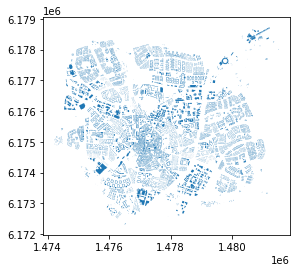

In [20]:
buildings.plot()

## Streets

In [14]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')

In [15]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [16]:
streets = osmnx.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)

In [17]:
streets.head()

osmid  \
u        v         key                                                      
27323965 27368538  0    [4453888, 1013393104, 29986647, 37878909, 3787...   
27368538 253109972 0                     [384735260, 404309645, 18877759]   
         27368549  0                                             29986642   
27368346 240522769 0                                             19786755   
         207416405 0                                            313678625   

                        oneway   lanes   ref        highway   maxspeed  \
u        v         key                                                   
27323965 27368538  0      True  [2, 3]  E 22       motorway        110   
27368538 253109972 0      True  [1, 2]   NaN  motorway_link  [50, 110]   
         27368549  0      True       2  E 22       motorway        110   
27368346 240522769 0     False     NaN   NaN       tertiary         40   
         207416405 0     False     NaN   NaN       tertiary         40   

                       reversed    length bridge  \
u        v         key                             
27323965 27368538  0      False  1626.245    yes   
27368538 253109972 0      False   216.088    NaN   
         27368549  0      False   567.749    NaN   
27368346 240522769 0       True    57.561    NaN   
         207416405 0      False    67.331    NaN   

                                                                 geometry  \
u        v         key                                                      
27323965 27368538  0    LINESTRING (1479055.768 6176220.080, 1479046.4...   
27368538 253109972 0    LINESTRING (1478803.129 6174612.265, 1478779.8...   
         27368549  0    LINESTRING (1478803.129 6174612.265, 1478796.7...   
27368346 240522769 0    LINESTRING (1476512.607 6175518.135, 1476491.3...   
         207416405 0    LINESTRING (1476512.607 6175518.135, 1476520.7...   

                                    name width tunnel access junction  
u        v         key                                                 
27323965 27368538  0                 NaN   NaN    NaN    NaN      NaN  
27368538 253109972 0                 NaN   NaN    NaN    NaN      NaN  
         27368549  0                 NaN   NaN    NaN    NaN      NaN  
27368346 240522769 0    Byggmästaregatan   NaN    NaN    NaN      NaN  
         207416405 0    Byggmästaregatan   NaN    NaN    NaN      NaN

In [18]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

streets.head()

/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/momepy/preprocessing.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


,geometry,nID
0,"LINESTRING (1479055.768 6176220.080, 1479046.4...",0
1,"LINESTRING (1478803.129 6174612.265, 1478779.8...",1
2,"LINESTRING (1478803.129 6174612.265, 1478796.7...",2
3,"LINESTRING (1476512.607 6175518.135, 1476491.3...",3
4,"LINESTRING (1476512.607 6175518.135, 1476520.7...",4


/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/filip/code/anaconda3/envs/gds/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


NameError: name 'plt' is not defined

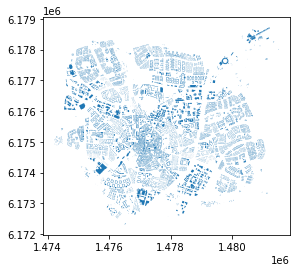

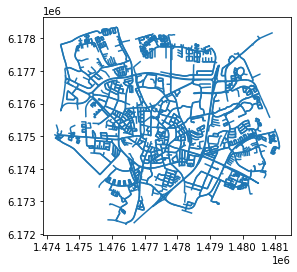

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
buildings.plot()
streets.plot()